In [1]:
%load_ext autoreload
%autoreload 

from preprocessing.preprocess_ucr import UCRDatasetImporter
from preprocessing.preprocess_ucr import UCRDataset
from preprocessing.preprocess_ucr import AugUCRDataset
from preprocessing.data_pipeline import build_data_pipeline
from utils import load_yaml_param_settings

from utils import time_to_timefreq, timefreq_to_time
from preprocessing.augmentations import TimeFreqAugmenter
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import torch.nn.functional as F
import math

/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
config = load_yaml_param_settings("configs/config.yaml")

config['dataset']['dataset_name'] = 'UWaveGestureLibraryAll'
config["VQVAE"]["n_fft"] = 8

# data pipeline
dataset_importer = UCRDatasetImporter(**config["dataset"])
batch_size = config["dataset"]["batch_sizes"]["stage1"]
train_data_loader = build_data_pipeline(
    batch_size, dataset_importer, config, "train", augment=False
)
test_data_loader = build_data_pipeline(batch_size, dataset_importer, config, "test")

augmenter = TimeFreqAugmenter(**config["augmentations"]["aug_params"])

self.X_train.shape: (896, 945)
self.X_test.shape: (3582, 945)
# unique labels (train): [0 1 2 3 4 5 6 7]
# unique labels (test): [0 1 2 3 4 5 6 7]


In [10]:
def get_x_u():
    X = torch.tensor(train_data_loader.dataset.X)
    x = X[np.random.randint(0, X.shape[0])]
    return x, augmenter.stft(x)


def plot(x, xaug, u, uaug):
    f, a = plt.subplots(1, 3, figsize=(15, 5))

    # Visualize the magnitude of the original and augmented STFT representations
    a[0].imshow(np.abs(u), aspect="auto", cmap="viridis")  # You can adjust the cmap
    a[1].imshow(np.abs(uaug), aspect="auto", cmap="viridis")  # You can adjust the cmap

    # Plot the original and augmented signals
    a[2].plot(x, label="original")
    a[2].plot(xaug, label="augmented")  # Include the augmented signal in the plot
    a[2].legend()

    plt.show()

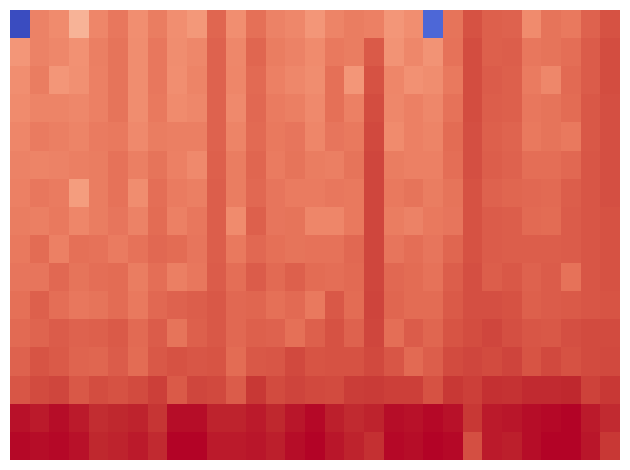

In [11]:
x, u = get_x_u()

#u_magnitude = np.abs(u)

# Create a figure and axes with no background
fig, ax = plt.subplots(facecolor='none')
ax.axis('off')  # Remove axes

# Plot the data with a colormap and alpha
#im = ax.imshow(u_magnitude, cmap='plasma')
im = ax.specgram(x, cmap="coolwarm", NFFT=30, noverlap=0)
# Add a colorbar
#fig.colorbar(im, ax=ax)

# Show the plot
plt.tight_layout()
plt.savefig("stft.png")

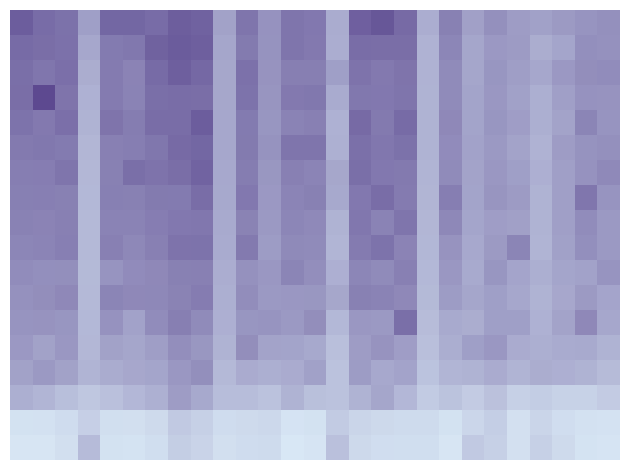

In [12]:
from matplotlib.colors import LinearSegmentedColormap

# Define the colors for the colormap
colors = ["#351c75", "#cfe2f3ff"]  # Blue to Purple

# Create the colormap
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

x, u = get_x_u()

# Create a figure and axes with no background
fig, ax = plt.subplots(facecolor='none')
ax.axis('off')  # Remove axes

# Plot the data with the custom colormap and alpha
im = ax.specgram(x, cmap=cmap, NFFT=34, interpolation="none", noverlap=0, alpha=.8)

# Show the plot
plt.tight_layout()
plt.savefig("stft.png")

(array([[2.20161881e+01, 2.23058158e+01, 1.36997016e+01, 1.78687326e+00,
         1.21640052e+00, 1.75112247e+01, 1.41534461e+01, 5.39532201e+00,
         5.63914718e-01, 1.30687059e+00, 5.40543442e+00, 7.91674523e+00,
         7.24826217e-02, 1.86491576e+01, 3.42498536e+01, 1.41762679e+01,
         7.52900038e-03, 2.90167075e+00, 5.98039205e+00, 8.60386311e+00,
         3.20478173e+00, 1.36881472e+01, 2.45262255e+01, 1.66520720e+00,
         4.31941910e-01, 1.15517829e+01, 5.57193574e-01, 3.00315152e+00,
         3.82099247e+01, 7.02074554e+00, 1.15657270e+01],
        [1.21359311e+01, 1.25320251e+01, 7.72719073e+00, 1.11135889e+00,
         3.90596387e-01, 1.00155145e+01, 7.77166043e+00, 3.10531201e+00,
         2.89576588e-01, 7.09687950e-01, 3.44745225e+00, 4.28884582e+00,
         6.18002351e-01, 1.13287621e+01, 1.95740970e+01, 8.60187374e+00,
         3.17510642e-01, 1.60349135e+00, 3.30367187e+00, 5.00740971e+00,
         1.70914974e+00, 7.52570938e+00, 1.48200928e+01, 1.1389848

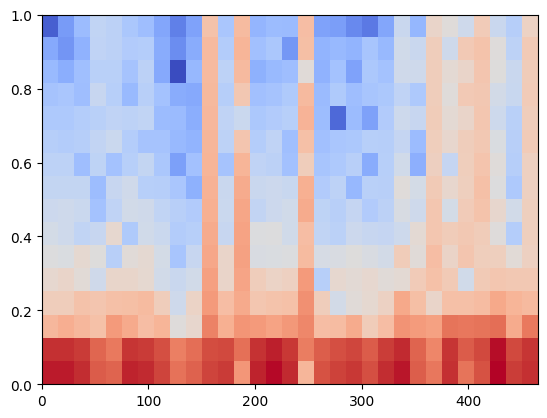

In [13]:
#plt.plot(x)
plt.specgram(x, NFFT=30, noverlap=0, cmap="coolwarm")

In [14]:
from preprocessing.augmentations import Augmenter

config = load_yaml_param_settings("configs/config.yaml")

aug = Augmenter(**config["augmentations"])

x, u = get_x_u()
xaugs = []

for _ in range(100):
    xaug, combination = aug.augment(x, return_combinations=True)
    xaugs.append(xaug)

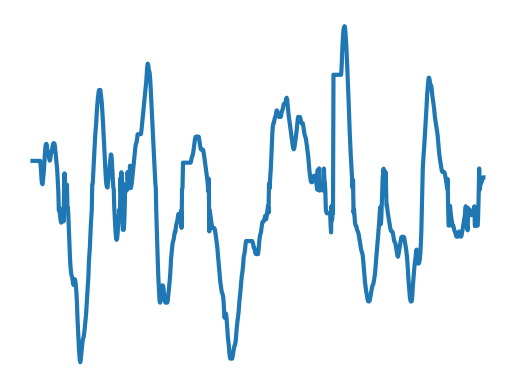

In [20]:
plt.axis('off')
# thicker linewidth
plt.plot(x, label="original", linewidth=3)
plt.savefig("original.png", bbox_inches='tight', transparent=True)

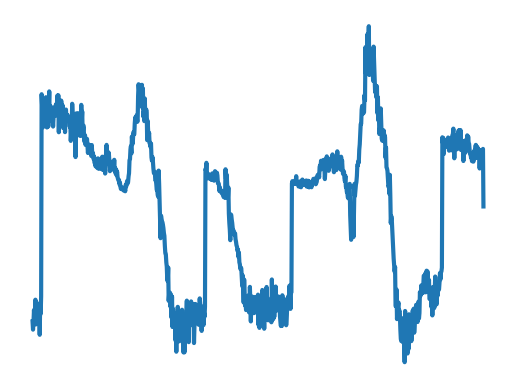

In [21]:
plt.axis('off')
plt.plot(xaugs[70], label="augmented", linewidth=3)
plt.savefig("augmented_signal.png", bbox_inches="tight", transparent=True)

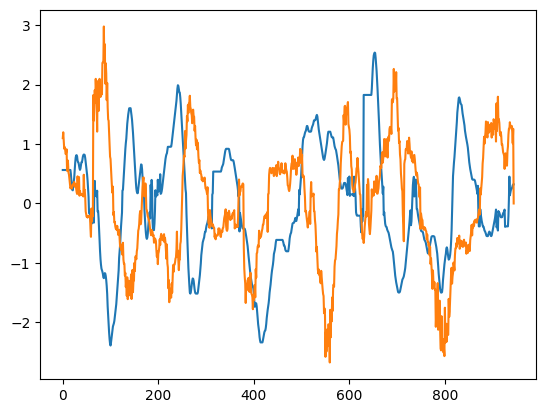

In [19]:
x, u = get_x_u()
xaug = aug.augment(x)
plt.plot(x)
plt.plot(xaug)

ValueError: num must be an integer with 1 <= num <= 12, not 13

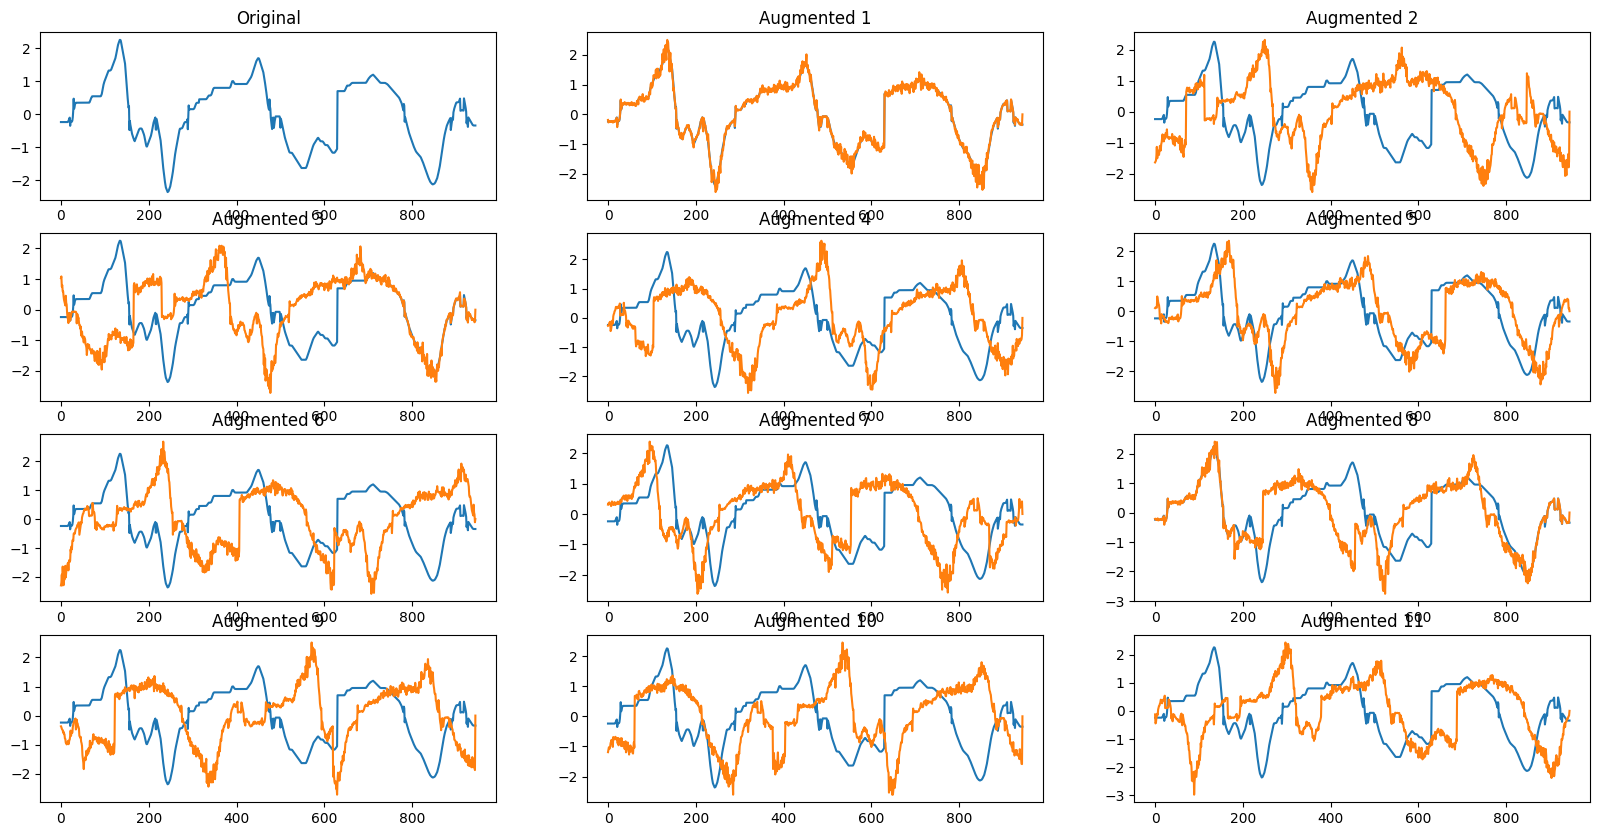

In [8]:
plt.figure(figsize=(20, 10))
plt.subplot(4, 3, 1)
plt.plot(x)
plt.title('Original')

# Plot augmented signals
for i in range(12):
    plt.subplot(4, 3, i+2)
    plt.plot(x, label='Original')
    xaug = aug.augment(x)
    plt.plot(xaug, label='Augmented')
    plt.title(f'Augmented {i+1}')

plt.tight_layout()
plt.show()#plot the original and augmented signals

In [ ]:
x, _ = get_x_u()
xaug = aug.augment(x)
plt.plot(x, label="original")
plt.show()
plt.close()
plt.plot(xaug, label="augmented")  # Include the augmented signal in the plot
plt.legend()
plt.show()#plot the original and augmented signals

NameError: name 'get_x_u' is not defined

In [ ]:
def add_gaussian_noise(*subx_views, mean=0, variance=1.0):
    """
    Add Gaussian noise to the input sequences.
    """
    noise_subx_views = []

    for subx in subx_views:
        noise = np.random.normal(mean, np.sqrt(variance), subx.shape)
        noise_subx = subx + noise
        noise_subx_views.append(noise_subx)

    if len(noise_subx_views) == 1:
        noise_subx_views = noise_subx_views[0]

    return noise_subx_views

def add_slice_and_shuffle(*subx_views, n_segments=2):
    """
    Slice the input sequences into segments and shuffle them.
    """
    shuffled_subx_views = []

    for subx in subx_views:
        # Randomly pick n_segments-1 points where to slice
        idxs = np.random.randint(0, subx.shape[0], size=n_segments - 1)
        slices = []
        start_idx = 0
        for j in sorted(idxs):
            s = subx[start_idx:j]
            start_idx = j
            slices.append(s)
        slices.append(subx[start_idx:])
        np.random.shuffle(slices)
        shuffled_subx = np.concatenate(slices)
        shuffled_subx_views.append(shuffled_subx)

    if len(shuffled_subx_views) == 1:
        shuffled_subx_views = shuffled_subx_views[0]

    return shuffled_subx_views

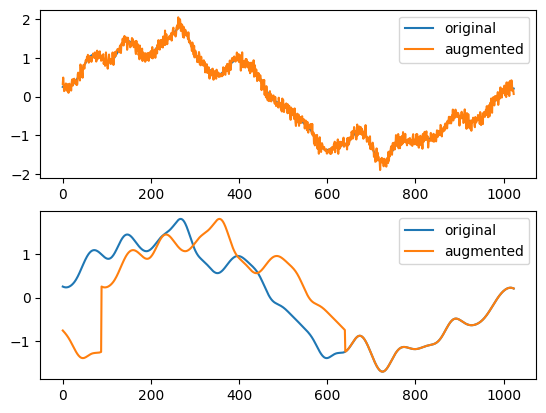

In [ ]:
x, u = get_x_u()

aug_noise = add_gaussian_noise(x, mean=0, variance=0.01)
xaug_shuffled = add_slice_and_shuffle(x, n_segments=4)

f, a = plt.subplots(2)
a[0].plot(x, label="original")
a[0].plot(aug_noise, label="augmented")
a[0].legend()
a[1].plot(x, label="original")
a[1].plot(xaug_shuffled, label="augmented")
a[1].legend()


In [ ]:
#